In [1]:
import os

from diff_viz import msd
from diff_viz import diffusion_modes
from diff_viz import feature_distribution_plots
from diff_viz import data_loading
from diff_viz import diff_utils
import pandas as pd
from os import getcwd, chdir
#from diff_predictor import data_process
from diff_viz import diff_utils
import matplotlib.pyplot as plt
import numpy as np
#import diff_classifier
from diff_classifier.features import unmask_track
import altair as alt

from diff_viz.heatmaps import plot_heatmap, plot_scatterplot, plot_trajectories
from diff_viz.viscosity import viscosity_from_diffusion_coefficient

In [2]:
phuong_data_path = '/Users/nelsschimek/Documents/nancelab/diff_visualizer/diff_viz/tests/testing_data/phuong_data/Compiled_Trajectories/'

In [3]:
healthy_files_cortex = os.listdir(phuong_data_path + '/Healthy_QD-BEV/cortex/')
ogd_files_cortex = os.listdir(phuong_data_path + '/OGD_QD-BEV/cortex')
print(len(healthy_files_cortex))
print(len(ogd_files_cortex))

16
32


In [4]:
healthy_files_striatum = os.listdir(phuong_data_path + '/Healthy_QD-BEV/striatum/')
ogd_files_striatum = os.listdir(phuong_data_path + '/OGD_QD-BEV/striatum')
print(len(healthy_files_striatum))
print(len(ogd_files_striatum))

45
57


In [5]:
msd_healthy_cortex = [file for file in healthy_files_cortex if 'msd_10' in file and 'Blank' not in file]
msd_ogd_cortex = [file for file in ogd_files_cortex if 'msd_10' in file and 'Blank' not in file]
print(len(msd_healthy_cortex))
print(len(msd_ogd_cortex))

msd_healthy_striatum = [file for file in healthy_files_striatum if 'msd_10' in file and 'Blank' not in file]
msd_ogd_striatum = [file for file in ogd_files_striatum if 'msd_10' in file and 'Blank' not in file]
print(len(msd_healthy_striatum))
print(len(msd_ogd_striatum))

6
12
13
22


In [6]:
# list_msd_healthy_cortex = []
# list_msd_ogd_cortex = []
# list_msd_healthy_striatum = []
# list_msd_ogd_striatum = []

# for file in msd_healthy_cortex:
#     msd_data = pd.read_csv(phuong_data_path + '/Healthy_QD-BEV/cortex/' + file)
#     geo_mean, geosem = msd.get_geo_data(msd_data)
#     list_msd_healthy_cortex.append(np.array(geo_mean))

# for file in msd_ogd_cortex:
#     msd_data = pd.read_csv(phuong_data_path + '/OGD_QD-BEV/cortex/' + file)
#     geo_mean, geosem = msd.get_geo_data(msd_data)
#     list_msd_ogd_cortex.append(geo_mean)

# for file in msd_healthy_striatum:
#     msd_data = pd.read_csv(phuong_data_path + '/Healthy_QD-BEV/striatum/' + file)
#     geo_mean, geosem = msd.get_geo_data(msd_data)
#     list_msd_healthy_striatum.append(geo_mean)

# for file in msd_ogd_striatum:
#     msd_data = pd.read_csv(phuong_data_path + '/OGD_QD-BEV/striatum/' + file)
#     geo_mean, geosem = msd.get_geo_data(msd_data)
#     list_msd_ogd_striatum.append(geo_mean)

In [7]:
import altair as alt
import pandas as pd
import numpy as np

def plot_trajectories_altair_interactive(msd_df, resolution=512, rows=4, cols=4, subset=False, size=1000, color_by='Track_ID'):
    """
    Plot interactive trajectories using Altair.

    Parameters
    ----------
    msd_df : DataFrame
        DataFrame containing the trajectories to be plotted.
    resolution : int
        Resolution of base image. Only needed to calculate bounds of image.
    rows : int
        Rows of base images used to build tiled image.
    cols : int
        Columns of base images used to build tiled images.
    subset : bool
        If True, a subset of 'size' trajectories will be randomly selected and plotted.
    size : int
        Number of trajectories to plot if subset is True.
    """
    # Determine the number of particles and select a subset if requested

    color_scale = alt.Scale(scheme='category10')  # You can customize the color scheme
    color_encoding = alt.Color(f'{color_by}:N', scale=color_scale, legend=None)  # Set legend=None to hide legend
    particles = msd_df['Track_ID'].nunique()
    if subset:
        selected_particles = np.random.choice(msd_df['Track_ID'].unique(), size=min(size, particles), replace=False)
        msd_df = msd_df[msd_df['Track_ID'].isin(selected_particles)]
    
    # Create the Altair chart
    chart = alt.Chart(msd_df).mark_line(opacity=0.7, color='black').encode(
        x=alt.X('X:Q', scale=alt.Scale(domain=(0, resolution*cols))),
        y=alt.Y('Y:Q', scale=alt.Scale(domain=(0, resolution*rows))),
        detail='Track_ID:N',  # This ensures each track is plotted as a separate line
        color=color_encoding
    ).properties(
        width=resolution*cols,
        height=resolution*rows
    ).configure_view(
        strokeWidth=0  # Removes the border around the chart
    ).interactive()  # Enables zoom and pan interactivity

    return chart


In [9]:
alt.data_transformers.disable_max_rows()
chart = plot_trajectories_altair_interactive(pd.read_csv(phuong_data_path + '/OGD_QD-BEV/cortex/' + msd_ogd_cortex[0]), resolution=256, rows=4, cols=4, subset=False, size=1000)

In [28]:
import pandas as pd
import numpy as np
import altair as alt

def sample_trajectories(msd_df, N=5, plot=False, resolution=512, rows=4, cols=4):
    """
    Return and optionally plot N randomly sampled trajectories.

    Parameters
    ----------
    msd_df : DataFrame
        DataFrame containing the trajectories to be sampled and plotted.
    N : int
        Number of trajectories to sample.
    plot : bool
        If True, plots the sampled trajectories.
    resolution : int
        Resolution of base image, used for plotting.
    rows : int
        Number of rows in the tiled image setup, used for plotting.
    cols : int
        Number of columns in the tiled image setup, used for plotting.

    Returns
    -------
    sampled_trajectories : DataFrame
        A DataFrame containing the sampled trajectories.
    charts : list of alt.Chart (optional)
        A list of Altair Chart objects if plotting is requested.
    """
    # Sample N unique track IDs without replacement

    # Setup color encoding based on the provided column
    color_scale = alt.Scale(scheme='category10')  # You can customize the color scheme
    color_encoding = alt.Color(f'{color_by}:N', scale=color_scale, legend=None)  # Set legend=None to hide legend
    
    unique_tracks = msd_df['Track_ID'].unique()
    sampled_track_ids = np.random.choice(unique_tracks, size=min(N, len(unique_tracks)), replace=False)
    
    # Filter the DataFrame to include only the sampled track IDs
    sampled_trajectories = msd_df[msd_df['Track_ID'].isin(sampled_track_ids)]
    
    if plot:
        charts = []
        for track_id in sampled_track_ids:
            track_df = sampled_trajectories[sampled_trajectories['Track_ID'] == track_id]
            chart = alt.Chart(track_df).mark_line(opacity=0.7, color='black').encode(
                x=alt.X('X:Q', scale=alt.Scale(domain=(0, resolution*cols))),
                y=alt.Y('Y:Q', scale=alt.Scale(domain=(0, resolution*rows))),
            ).properties(
                title=f'Track ID: {track_id}',
                width=400,
                height=400
            ).interactive()
            charts.append(chart)
        return sampled_trajectories, charts

    return sampled_trajectories


In [7]:
def get_traj_list(df):   

    output_df = pd.DataFrame()

    trackids = df.Track_ID.unique()
    partcount = trackids.shape[0]

    for particle in range(0, partcount):
        single_track_masked =\
            df.loc[df['Track_ID'] ==
                    trackids[particle]].sort_values(['Track_ID', 'Frame'],
                                                    ascending=[
                                                    1,
                                                    1]).reset_index(drop=True)
        single_track = unmask_track(single_track_masked)
        # alph, coef = alpha_calc(single_track)
        # if (len(single_track) > 66) & (alph > 0):
        #     rc_short = (single_track['MSDs'][33] / 4 * 33) / (single_track['MSDs'][7] / 4*7)
        #     rc_long = (single_track['MSDs'][66] / 4 * 66) / (single_track['MSDs'][33] / 4*33)
        #     new_dict = {
        #         'X': single_track['X'],
        #         'Y': single_track['Y'],
        #         'alpha': alph,
        #         'rc_short': rc_short,
        #         'rc_long': rc_long
        #    }
        if output_df.empty:
            output_df = single_track
        else:
            output_df = pd.concat([output_df, single_track])
    return output_df

In [13]:
test_df = pd.read_csv(phuong_data_path + '/OGD_QD-BEV/cortex/' + msd_ogd_cortex[6])
test_df['Track_ID'].nunique()

228

In [14]:
output = get_traj_list(pd.read_csv(phuong_data_path + '/OGD_QD-BEV/cortex/' + msd_ogd_cortex[0]))
output['Track_ID'].nunique()

449

In [9]:
def plot_all_particles_altair(df, color_by='Track_ID'):

    brush = alt.selection_interval()
    # Setup color encoding based on the provided column
    color_scale = alt.Scale(scheme='category10')  # You can customize the color scheme
    color_encoding = alt.Color(f'{color_by}:N', scale=color_scale, legend=None)  # Set legend=None to hide legend
       # Create the Altair chart
    trajectories = alt.Chart(df).mark_line(opacity=0.7).encode(
        x=alt.X('X:Q'),# scale=alt.Scale(domain=(0, resolution*cols))),
        y=alt.Y('Y:Q'),# scale=alt.Scale(domain=(0, resolution*rows))),
        color=color_encoding,
        detail='Track_ID:N',  # This ensures each track is plotted as a separate line
        order='Frame:N',
    # ).properties(
    #     width=resolution*cols,
    #     height=resolution*rows
    # ).configure_view(
    #     strokeWidth=0  # Removes the border around the chart
    ).add_selection(
        brush
    )  # Enables zoom and pan interactivity

    # Text mark to show unique Track IDs based on the selection
    unique_track_ids = alt.Chart(df).mark_text(align='left', dx=5, dy=-5).encode(
        x=alt.value(5),  # Position the text to the right of the selection
        y=alt.value(5),  # Position the text to the top of the selection
        text=alt.Text('Track_ID:N', aggregate='distinct'),
        opacity=alt.condition(brush, alt.value(1), alt.value(0))
    ).transform_filter(
        brush
    )
    chart = trajectories + unique_track_ids

    return chart

In [10]:
import altair as alt
import pandas as pd
import numpy as np

# Assuming df is your DataFrame with 'X', 'Y', 'Track_ID', and 'Frame' columns

def plot_all_particles_altair_with_side_panel(df, color_by='Track_ID'):
    # Define an interval selection for selecting points in the plot
    brush = alt.selection_interval()

    # Setup color encoding based on the provided column
    color_scale = alt.Scale(scheme='category10')  # Customize the color scheme
    color_encoding = alt.Color(f'{color_by}:N', scale=color_scale, legend=None)  # Hide legend

    # Create the Altair chart for trajectories with interactive selection
    trajectories = alt.Chart(df).mark_line(opacity=0.7).encode(
        x='X:Q',
        y='Y:Q',
        color=color_encoding,
        detail='Track_ID:N',  # Ensures each track is plotted as a separate line
    ).add_params(
        brush  # Adds interactive selection
    ).properties(
        width=500,
        height=300
    )

    # Creating a chart for displaying unique Track_IDs based on the selection
    # Use transform_filter to filter based on brush, and transform_window to ensure uniqueness
    unique_track_ids = alt.Chart(df).transform_filter(
        brush
    ).transform_aggregate(
        unique_ids='distinct(Track_ID)',
        groupby=['Track_ID']
    ).mark_text().encode(
        y=alt.Y('Track_ID:N', sort='ascending', axis=alt.Axis(title="Selected Track IDs")),
        text='Track_ID:N',
    ).properties(
        width=150,  # Adjust width as needed
        height=300  # Match height to the trajectories chart
    )

    # Combine the trajectories chart with the unique Track_IDs text chart
    chart = alt.hconcat(trajectories, unique_track_ids, spacing=30)  # Adjust spacing as needed

    return chart


In [18]:
plot_all_particles_altair_with_side_panel(output)

alt.HConcatChart(...)

In [27]:
output = get_traj_list(pd.read_csv(phuong_data_path + '/OGD_QD-BEV/cortex/' + msd_ogd_cortex[0]))
output

Frame  Track_ID            X           Y       MSDs     Gauss   Quality  \
0     0.0       0.0   471.461463  916.225936   0.000000  0.000000  2.138031   
1     1.0       0.0   471.705896  918.293975   4.567038  1.094058  2.883835   
2     2.0       0.0   471.505040  919.750536   7.957341  0.874792  1.930573   
3     3.0       0.0   474.261742  919.151395   9.812819  1.095751  1.759537   
4     4.0       0.0   473.308844  919.168427  11.911441  0.908987  1.847839   
..    ...       ...          ...         ...        ...       ...       ...   
30   30.0     448.0  1023.000000  353.000000  16.400000  1.029893  1.598068   
31   31.0     448.0  1023.000000  354.000000  10.750000  0.955111  1.352936   
32   32.0     448.0  1023.000000  352.000000  19.666667  1.069951  1.342468   
33   33.0     448.0  1023.000000  350.000000   8.500000  0.889273  1.332001   
34   34.0     448.0  1023.000000  347.000000   4.000000  0.500000  1.707047   

    SN_Ratio  Mean_Intensity  
0   0.444390      183.778281  
1   0.709367      186.425339  
2   0.510564      182.841629  
3   0.468868      182.918552  
4   0.504238      182.244344  
..       ...             ...  
30  0.637992      147.891403  
31  0.618016      147.416290  
32  0.619287      147.703620  
33  0.620559      147.990950  
34  0.630096      148.936652  

[30109 rows x 9 columns]

In [8]:
def plot_all_particles(df):
    fig = plt.figure()
    for track_id in df['Track_ID'].unique():
        plt.plot(df[df['Track_ID'] == track_id]['X'], df[df['Track_ID'] == track_id]['Y'])
    
    # Set x and y ticks in increments of 50
    plt.xticks(np.arange(min(df['X']), max(df['X'])+1, 100))
    plt.yticks(np.arange(min(df['Y']), max(df['Y'])+1, 100))
    
    plt.grid()
    return fig

msd_100X_OGD_Striatum_Slice1_Video2.csv


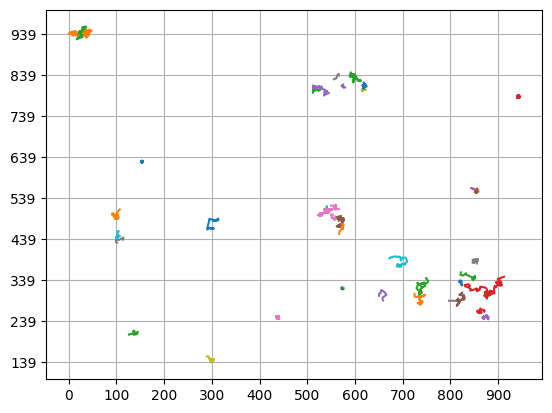

In [18]:
file_name = msd_ogd_striatum[8]
print(file_name)

output = get_traj_list(pd.read_csv(phuong_data_path + '/OGD_QD-BEV/striatum/' + file_name))
fig = plot_all_particles(output)

In [12]:
def remove_tracks_from_track_ids(df, track_ids_to_remove):
    return df[~df['Track_ID'].isin(track_ids_to_remove)]

In [13]:
output['Track_ID'].nunique()

69

In [19]:
tracks_to_remove= [

2, 29, 24, 10, 5, 7, 9, 11, 13, 15, 18, 20, 21, 23, 25, 16, 19, 36, 51, 39, 48, 50,
42, 45, 34
]

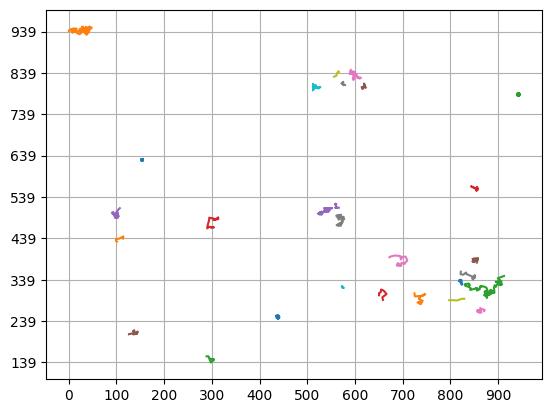

In [20]:
fig = plot_all_particles(remove_tracks_from_track_ids(output, tracks_to_remove))

In [21]:
new_df = remove_tracks_from_track_ids(output, tracks_to_remove)
print(new_df['Track_ID'].nunique())

28


In [22]:
new_df.to_csv('edited_'+ file_name)

In [47]:
def remove_tracks_from_x_y_coords(df, x_start, x_end, y_start, y_end):
    """
    Remove tracks that are within the specified x and y coordinates.

    Parameters
    ----------
    df : DataFrame
        DataFrame containing the trajectories to be filtered.
    x_start : int
        Starting x coordinate.
    x_end : int
        Ending x coordinate.
    y_start : int
        Starting y coordinate.
    y_end : int
        Ending y coordinate.

    Returns
    -------
    df : DataFrame
        A DataFrame containing the filtered trajectories.
    """
    df = df[~((df['X'] > x_start) & (df['X'] < x_end) & (df['Y'] > y_start) & (df['Y'] < y_end))]
    return df